<a href="https://colab.research.google.com/github/larinsi/DS0P/blob/main/Machine_learning_Middle_level_Neural_networks/07_Semantic_segmentation_Pt2/Homework/%D0%A1%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [1]:
# !mkdir -p data

# !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip

# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && make

### Импорт необходимых библиотек

In [2]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [3]:
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

2022-05-04 19:13:31.014929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


TensorFlow version: 2.4.1


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [4]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [22]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(...)
val_ds = COCO_dataset_val.val_dataset(...)

loading annotations into memory...
Done (t=21.99s)
creating index...
index created!
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


TypeError: train_dataset() missing 2 required positional arguments: 'epochs' and 'inp_size'

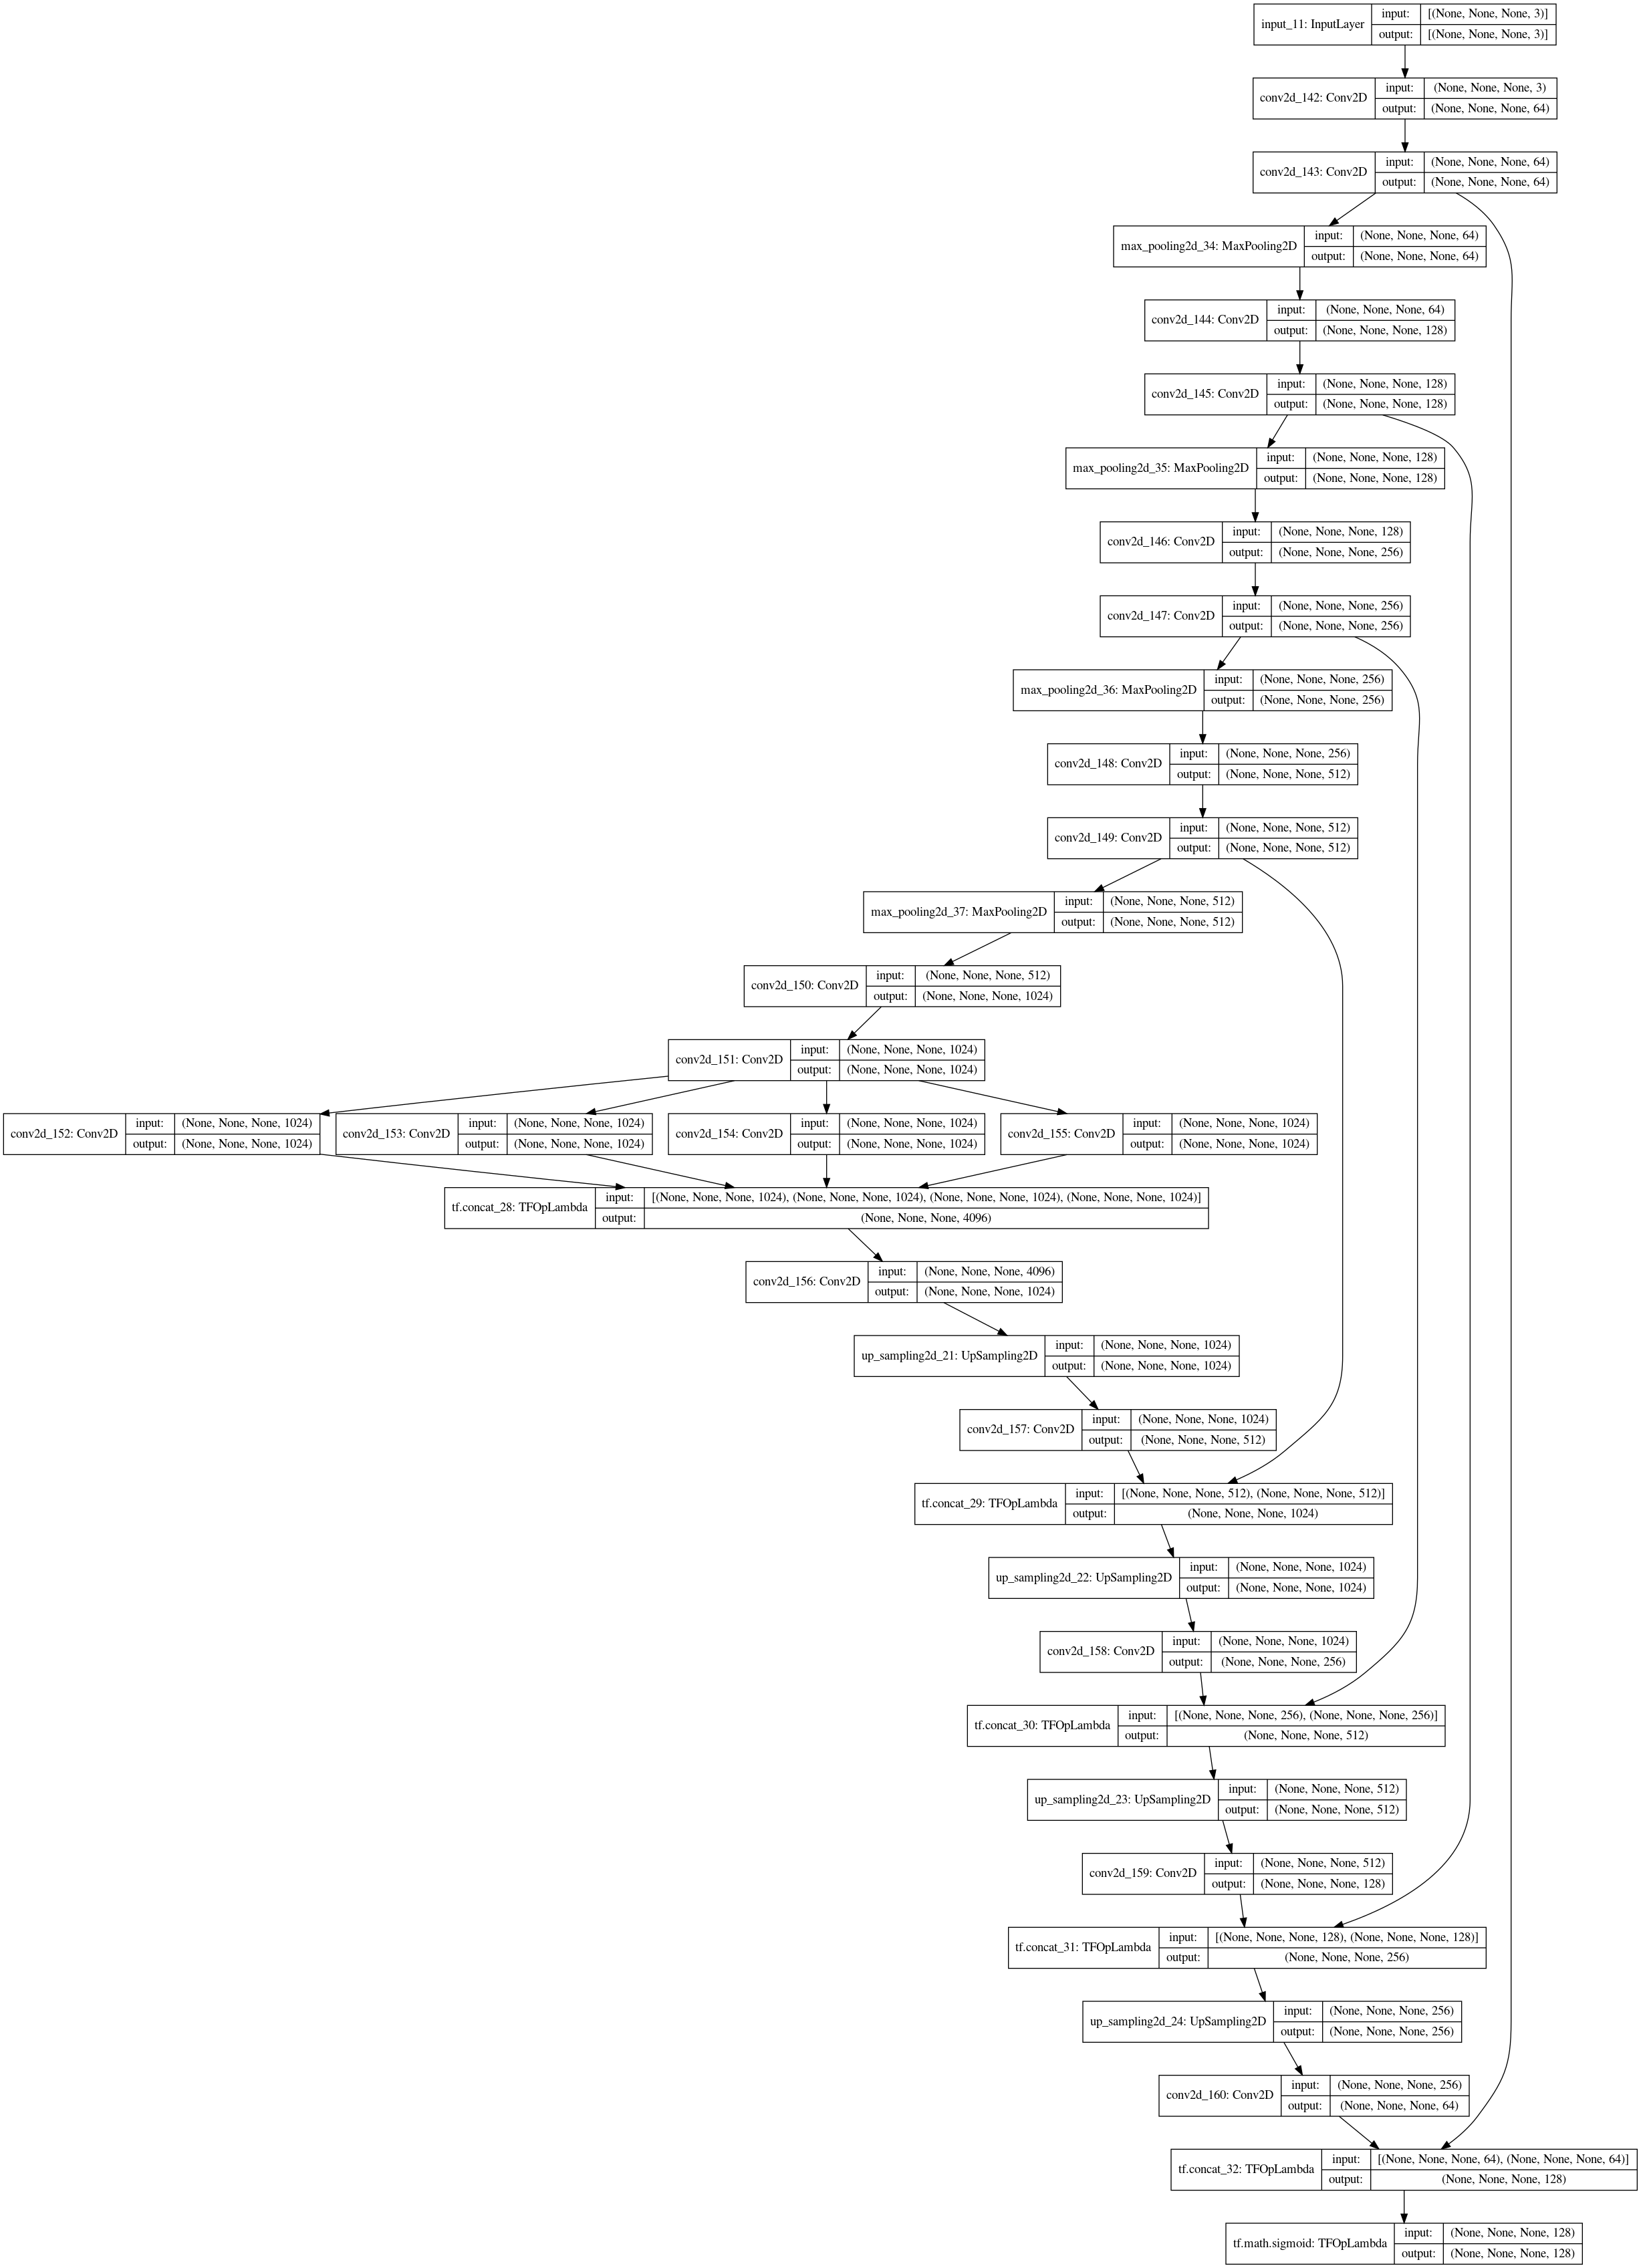

In [20]:
# Создаем модель
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.utils import plot_model

input_layer = tf.keras.layers.Input((None, None, 3))

out = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
out1 = Conv2D(64, (3, 3), activation='relu', padding='same')(out)
out = MaxPool2D((2, 2), (2, 2))(out1)

out = Conv2D(128, (3, 3), activation='relu', padding='same')(out)
out2 = Conv2D(128, (3, 3), activation='relu', padding='same')(out)
out = MaxPool2D((2, 2), (2, 2))(out2)

out = Conv2D(256, (3, 3), activation='relu', padding='same')(out)
out3 = Conv2D(256, (3, 3), activation='relu', padding='same')(out)
out = MaxPool2D((2, 2), (2, 2))(out3)

out = Conv2D(512, (3, 3), activation='relu', padding='same')(out)
out4 = Conv2D(512, (3, 3), activation='relu', padding='same')(out)
out = MaxPool2D((2, 2), (2, 2))(out4)

out = Conv2D(1024, (3, 3), activation='relu', padding='same')(out)
out = Conv2D(1024, (3, 3), activation='relu', padding='same')(out)

# ASPP
aspp1_out = Conv2D(1024, (1, 1), activation='relu', padding='same')(out)
aspp2_out = Conv2D(1024, (3, 3), dilation_rate=6, activation='relu', padding='same')(out)
aspp3_out = Conv2D(1024, (3, 3), dilation_rate=12, activation='relu', padding='same')(out)
aspp4_out = Conv2D(1024, (3, 3), dilation_rate=18, activation='relu', padding='same')(out)
out = tf.concat([aspp1_out, aspp2_out, aspp3_out, aspp4_out], axis=3)
out = Conv2D(1024, (1, 1), activation='relu', padding='same')(out)

out = UpSampling2D((2, 2))(out)
out = Conv2D(512, (3, 3), activation='relu', padding='same')(out)
out = tf.concat([out, out4], axis=3)

out = UpSampling2D((2, 2))(out)
out = Conv2D(256, (3, 3), activation='relu', padding='same')(out)
out = tf.concat([out, out3], axis=3)

out = UpSampling2D((2, 2))(out)
out = Conv2D(128, (3, 3), activation='relu', padding='same')(out)
out = tf.concat([out, out2], axis=3)

out = UpSampling2D((2, 2))(out)
out = Conv2D(64, (3, 3), activation='relu', padding='same')(out)
out = tf.concat([out, out1], axis=3)

# out = tf.image.resize(out, tf.shape((None, None, 3))[1:3], tf.image.ResizeMethod.BILINEAR)
out = tf.nn.sigmoid(out)

model = tf.keras.Model(inputs=input_layer, outputs=out)
plot_model(model, show_shapes=True)

In [21]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss=loss, optimizer=optimizer)

model.fit(COCO_dataset_train, COCO_dataset_val, epochs=1)

ValueError: Failed to find data adapter that can handle input: <class '__main__.COCO_Dataset'>, <class '__main__.COCO_Dataset'>